In [1]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3
from keras.applications import VGG16

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

2024-05-21 17:09:53.905578: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 17:09:53.905696: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 17:09:54.178126: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# loading the dataset
def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            
            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df

In [3]:
# loading the data
data_dir = '/kaggle/input/skin-disease-dataset/dataset/train'
df = loading_the_data(data_dir)

df

filepaths  \
0      /kaggle/input/skin-disease-dataset/dataset/tra...   
1      /kaggle/input/skin-disease-dataset/dataset/tra...   
2      /kaggle/input/skin-disease-dataset/dataset/tra...   
3      /kaggle/input/skin-disease-dataset/dataset/tra...   
4      /kaggle/input/skin-disease-dataset/dataset/tra...   
...                                                  ...   
10185  /kaggle/input/skin-disease-dataset/dataset/tra...   
10186  /kaggle/input/skin-disease-dataset/dataset/tra...   
10187  /kaggle/input/skin-disease-dataset/dataset/tra...   
10188  /kaggle/input/skin-disease-dataset/dataset/tra...   
10189  /kaggle/input/skin-disease-dataset/dataset/tra...   

                            labels  
0                           Eczema  
1                           Eczema  
2                           Eczema  
3                           Eczema  
4                           Eczema  
...                            ...  
10185  Tinea Ringworms Candidiasis  
10186  Tinea Ringworms Candidiasis  
10187  Tinea Ringworms Candidiasis  
10188  Tinea Ringworms Candidiasis  
10189  Tinea Ringworms Candidiasis  

[10190 rows x 2 columns]

In [10]:
df['labels'].unique()

array(['Eczema', 'Melanoma', 'Basal Cell', 'Seborrheic',
       'Atopic Dermatitis', 'Melanocytic', 'Benign Keratosis',
       'Warts Molluscum', 'Psoriasis', 'Tinea Ringworms Candidiasis'],
      dtype=object)

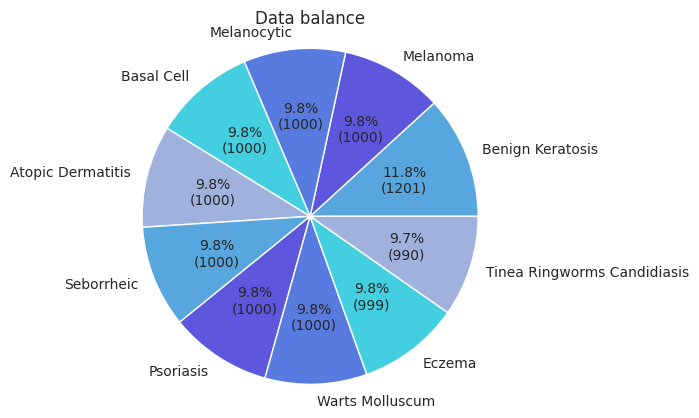

In [4]:
data_balance = df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#57A6DE","#5D57DE","#577BDE","#43CFE0","#A0B1DE"])
plt.title("Data balance")
plt.axis("equal")
plt.show()


In [5]:
# data --> 80% train data && 20% (test, val)
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

# test data --> 10% train data && 10% (test, val)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [6]:
batch_size = 16
img_size = (224, 224)

# Create generators for the data
tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)


# Convert the data
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 8152 validated image filenames belonging to 10 classes.
Found 1019 validated image filenames belonging to 10 classes.
Found 1019 validated image filenames belonging to 10 classes.


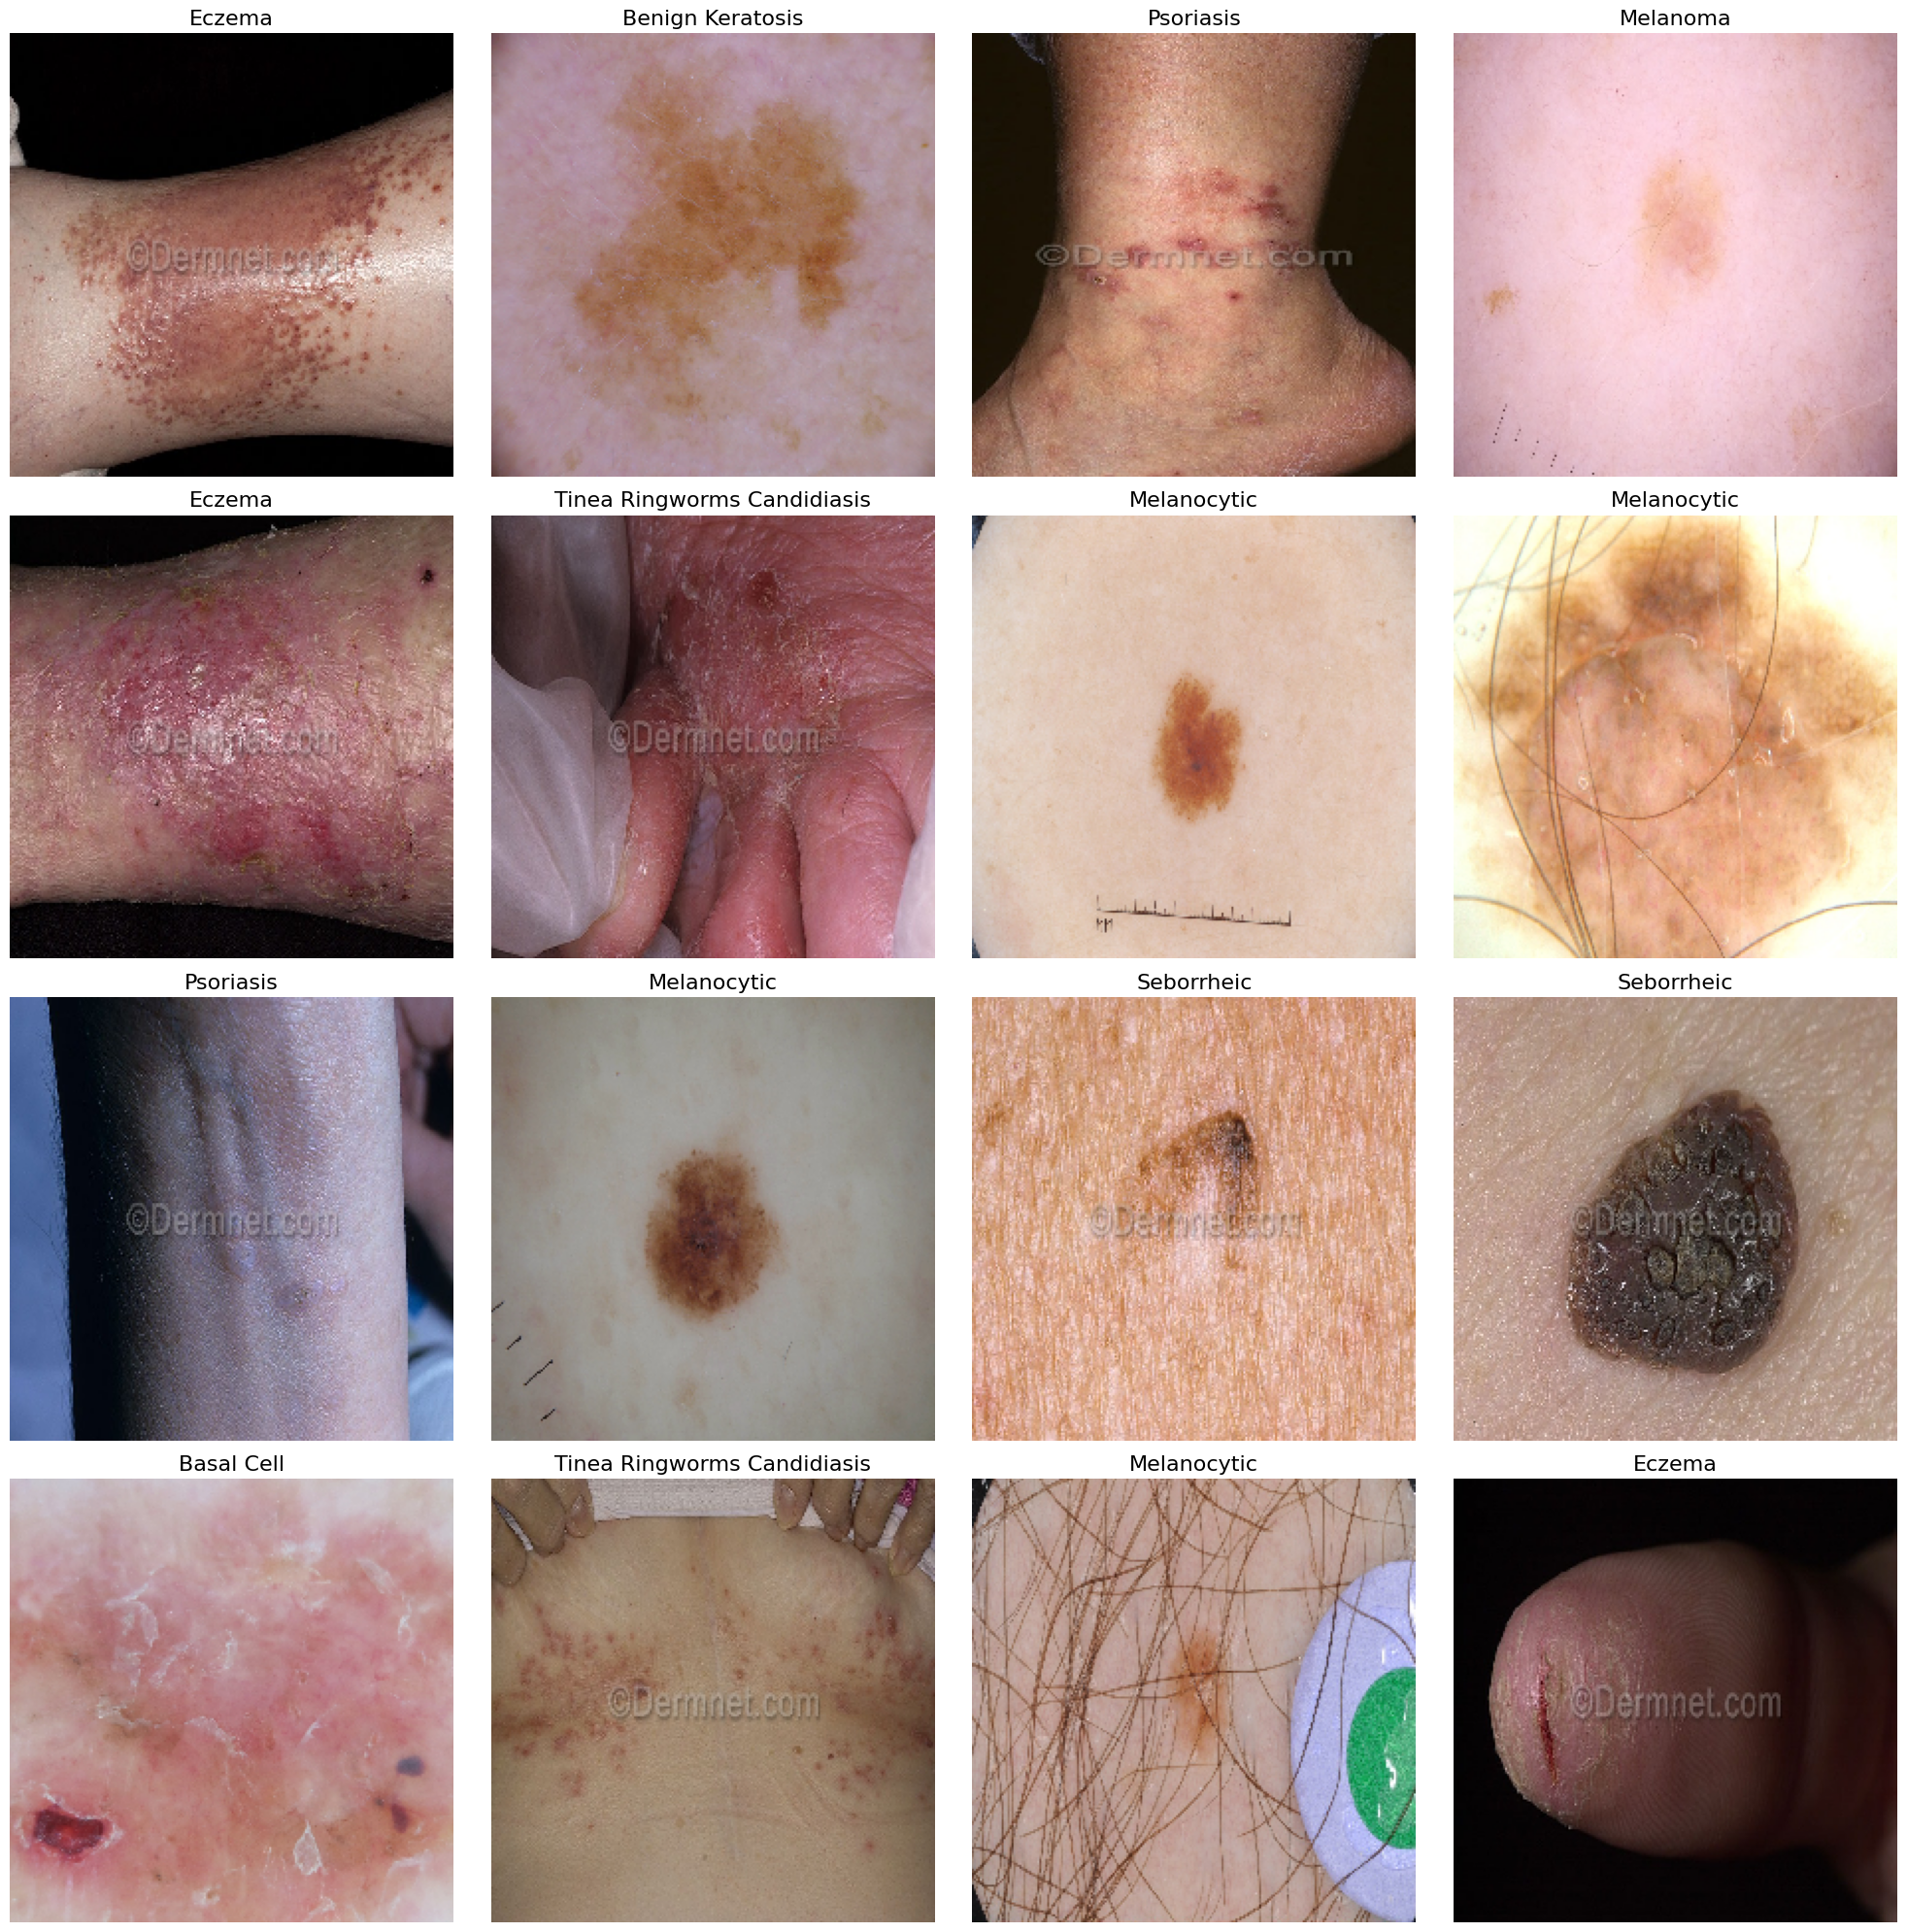

In [11]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [12]:
# Displaying the model performance
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    Epochs = [i+1 for i in range(len(tr_acc))]
    
    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()
    

# Evaluate the model
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)
    
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])
    

# Get Predictions
def get_pred(model, test_gen):
    
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)
    
    return y_pred


# Confusion Matrix
def plot_confusion_matrix(test_gen, y_pred):
    
    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())
    
    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.show()
    
    
# Defining a convolutional NN block for a sequential CNN model
def conv_block(filters, act='relu'):
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())
    
    return block


# Defining a dense NN block for a sequential CNN model
def dense_block(units, dropout_rate, act='relu'):
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [14]:
# create Model structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys()))     # to define number of classes in dense layer
print(class_counts)

10


In [15]:
# Model architecture
cnn_model = Sequential()

# first conv block
cnn_model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D())

# second conv block
cnn_model.add(conv_block(32))

# third conv block
cnn_model.add(conv_block(64))

# fourth conv bolck
cnn_model.add(conv_block(128))

# fifth conv block
cnn_model.add(conv_block(256))

# sixth conv block
cnn_model.add(conv_block(512))

# flatten layer
cnn_model.add(Flatten())

# first dense block
cnn_model.add(dense_block(256, 0.5))

# second dense block
cnn_model.add(dense_block(128, 0.3))

# third dense block
cnn_model.add(dense_block(64, 0.2))

# fourth dense block
cnn_model.add(dense_block(32, 0.2))

# output layer
cnn_model.add(Dense(class_counts, activation = "softmax"))

In [16]:
cnn_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 56, 56, 32)     │        14,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 28, 28, 64)     │        55,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 14, 14, 128)    │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 7, 7, 256)      │       886,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 3, 3, 512)      │     3,542,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 256)            │     1,180,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 128)            │        33,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 32)             │         2,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,945,834 (22.68 MB)

 Trainable params: 5,942,858 (22.67 MB)

 Non-trainable params: 2,976 (11.62 KB)

In [17]:
# train the model
epochs = 50   # number of all epochs in training

history = cnn_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/50
  2/510 ━━━━━━━━━━━━━━━━━━━━ 27s 54ms/step - accuracy: 0.0938 - loss: 3.2261   

I0000 00:00:1716311686.309139     177 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716311686.339902     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


510/510 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.1689 - loss: 2.5610

W0000 00:00:1716311791.818326     176 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716311793.622106     174 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


510/510 ━━━━━━━━━━━━━━━━━━━━ 150s 238ms/step - accuracy: 0.1690 - loss: 2.5606 - val_accuracy: 0.1668 - val_loss: 2.6143
Epoch 2/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 111s 102ms/step - accuracy: 0.2368 - loss: 2.1117 - val_accuracy: 0.2866 - val_loss: 2.1510
Epoch 3/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 53s 103ms/step - accuracy: 0.2938 - loss: 1.9222 - val_accuracy: 0.3209 - val_loss: 1.7516
Epoch 4/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 54s 105ms/step - accuracy: 0.3001 - loss: 1.8507 - val_accuracy: 0.3935 - val_loss: 1.5900
Epoch 5/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 54s 105ms/step - accuracy: 0.3418 - loss: 1.7294 - val_accuracy: 0.2463 - val_loss: 2.2558
Epoch 6/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 52s 103ms/step - accuracy: 0.3646 - loss: 1.6764 - val_accuracy: 0.4298 - val_loss: 1.4898
Epoch 7/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 53s 103ms/step - accuracy: 0.3804 - loss: 1.6316 - val_accuracy: 0.4043 - val_loss: 1.6598
Epoch 8/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 53s 104ms/step - accuracy: 0.3924 - loss: 1.5664 - v

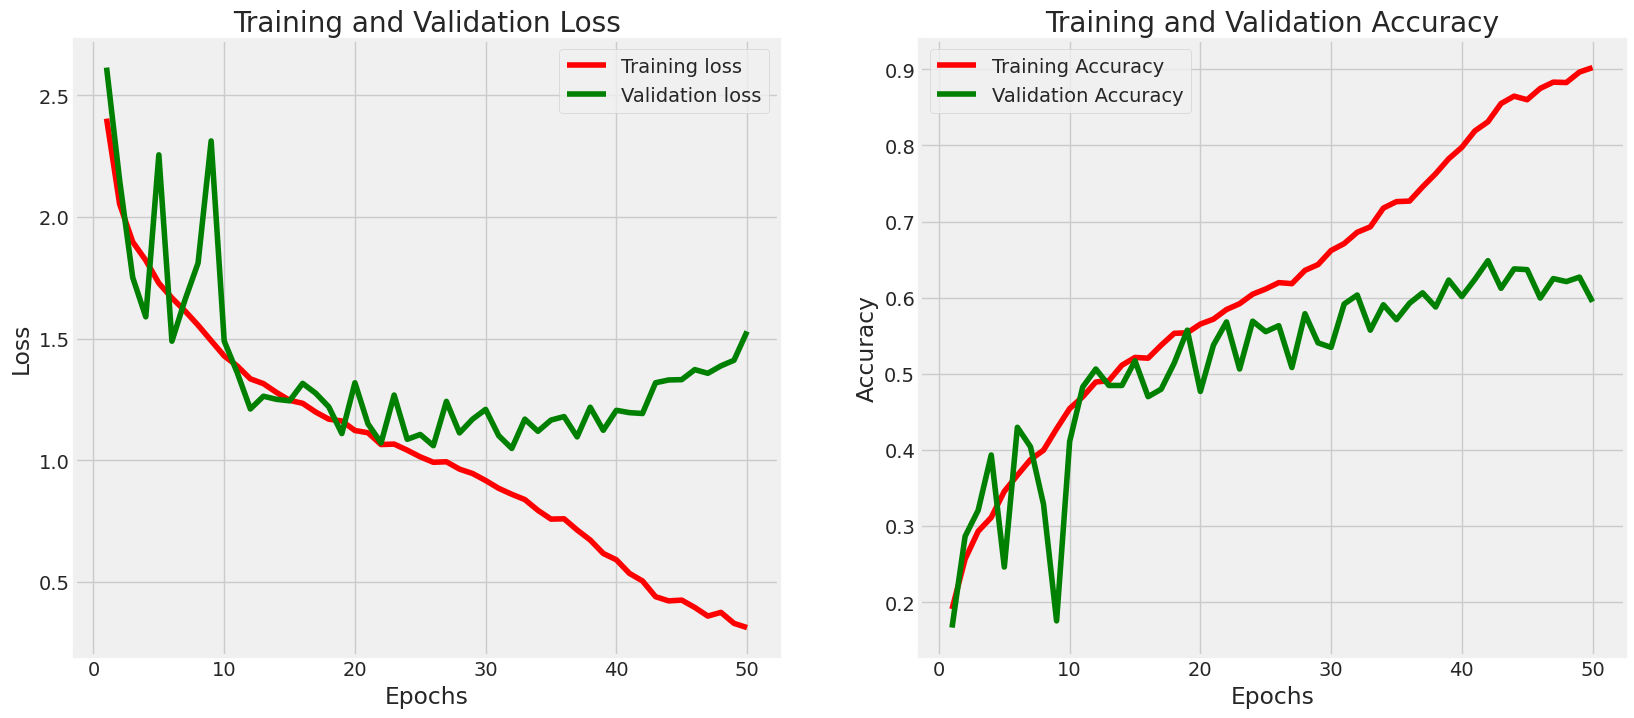

In [18]:
# Display model performance
model_performance(history, epochs)

In [19]:
# Model evaluation
model_evaluation(cnn_model)

510/510 ━━━━━━━━━━━━━━━━━━━━ 46s 91ms/step - accuracy: 0.9261 - loss: 0.2405


W0000 00:00:1716314566.338390     174 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.6057 - loss: 1.4598
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - accuracy: 0.6114 - loss: 1.4924
Train Loss:  0.24517962336540222
Train Accuracy:  0.9234543442726135
--------------------
Validation Loss:  1.529931902885437
Validation Accuracy:  0.5947006940841675
--------------------
Test Loss:  1.4160245656967163
Test Accuracy:  0.6339548826217651


 4/64 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step

W0000 00:00:1716314585.544448     175 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step


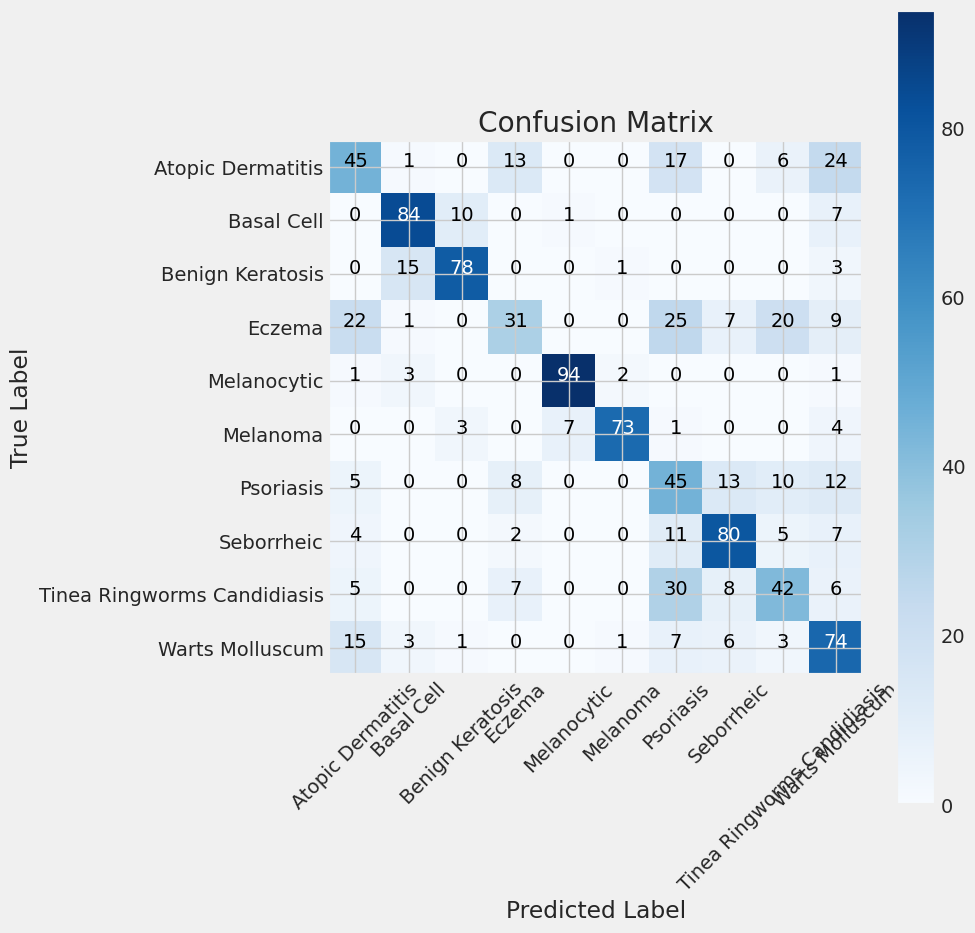

In [20]:
# get predictions
y_pred = get_pred(cnn_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)

In [33]:
cnn_model.save("/kaggle/working/cnn_model.h5")

ValueError: Unable to synchronously create dataset (name already exists)

# EfficientNetB3

In [25]:
# get the pre-trained model (EfficientNetB3)
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape = img_shape, pooling= None)

# fine-tune EfficientNetB3 (Adding some custom layers on top)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = dense_block(128, 0.5)(x)
x = dense_block(32, 0.2)(x)
predictions = Dense(class_counts, activation = "softmax")(x)    # output layer with softmax activation

# the model
EfficientNetB3_model = Model(inputs = base_model.input, outputs = predictions)

In [26]:
EfficientNetB3_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

EfficientNetB3_model.summary()

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_13[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 10,991,513 (41.93 MB)

 Trainable params: 10,900,818 (41.58 MB)

 Non-trainable params: 90,695 (354.28 KB)

In [34]:
# train the model
epochs = 24   # number of all epochs in training

EfficientNetB3_history = EfficientNetB3_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/24
510/510 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.1730 - loss: 2.6003

W0000 00:00:1716317758.425208     175 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716317766.984802     175 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


510/510 ━━━━━━━━━━━━━━━━━━━━ 167s 328ms/step - accuracy: 0.1731 - loss: 2.5999 - val_accuracy: 0.1079 - val_loss: 2.5840
Epoch 2/24


W0000 00:00:1716317777.685923     175 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


510/510 ━━━━━━━━━━━━━━━━━━━━ 78s 153ms/step - accuracy: 0.3302 - loss: 1.9434 - val_accuracy: 0.4917 - val_loss: 1.4555
Epoch 3/24
510/510 ━━━━━━━━━━━━━━━━━━━━ 79s 156ms/step - accuracy: 0.4214 - loss: 1.6336 - val_accuracy: 0.5496 - val_loss: 1.2949
Epoch 4/24
510/510 ━━━━━━━━━━━━━━━━━━━━ 78s 153ms/step - accuracy: 0.5020 - loss: 1.4360 - val_accuracy: 0.5898 - val_loss: 1.1590
Epoch 5/24
510/510 ━━━━━━━━━━━━━━━━━━━━ 78s 153ms/step - accuracy: 0.5305 - loss: 1.3471 - val_accuracy: 0.6408 - val_loss: 1.0618
Epoch 6/24
510/510 ━━━━━━━━━━━━━━━━━━━━ 78s 153ms/step - accuracy: 0.5732 - loss: 1.2220 - val_accuracy: 0.6546 - val_loss: 0.9917
Epoch 7/24
510/510 ━━━━━━━━━━━━━━━━━━━━ 78s 153ms/step - accuracy: 0.6097 - loss: 1.1458 - val_accuracy: 0.6860 - val_loss: 0.9457
Epoch 8/24
510/510 ━━━━━━━━━━━━━━━━━━━━ 78s 153ms/step - accuracy: 0.6347 - loss: 1.0699 - val_accuracy: 0.6938 - val_loss: 0.9019
Epoch 9/24
510/510 ━━━━━━━━━━━━━━━━━━━━ 78s 153ms/step - accuracy: 0.6709 - loss: 0.9707 - val

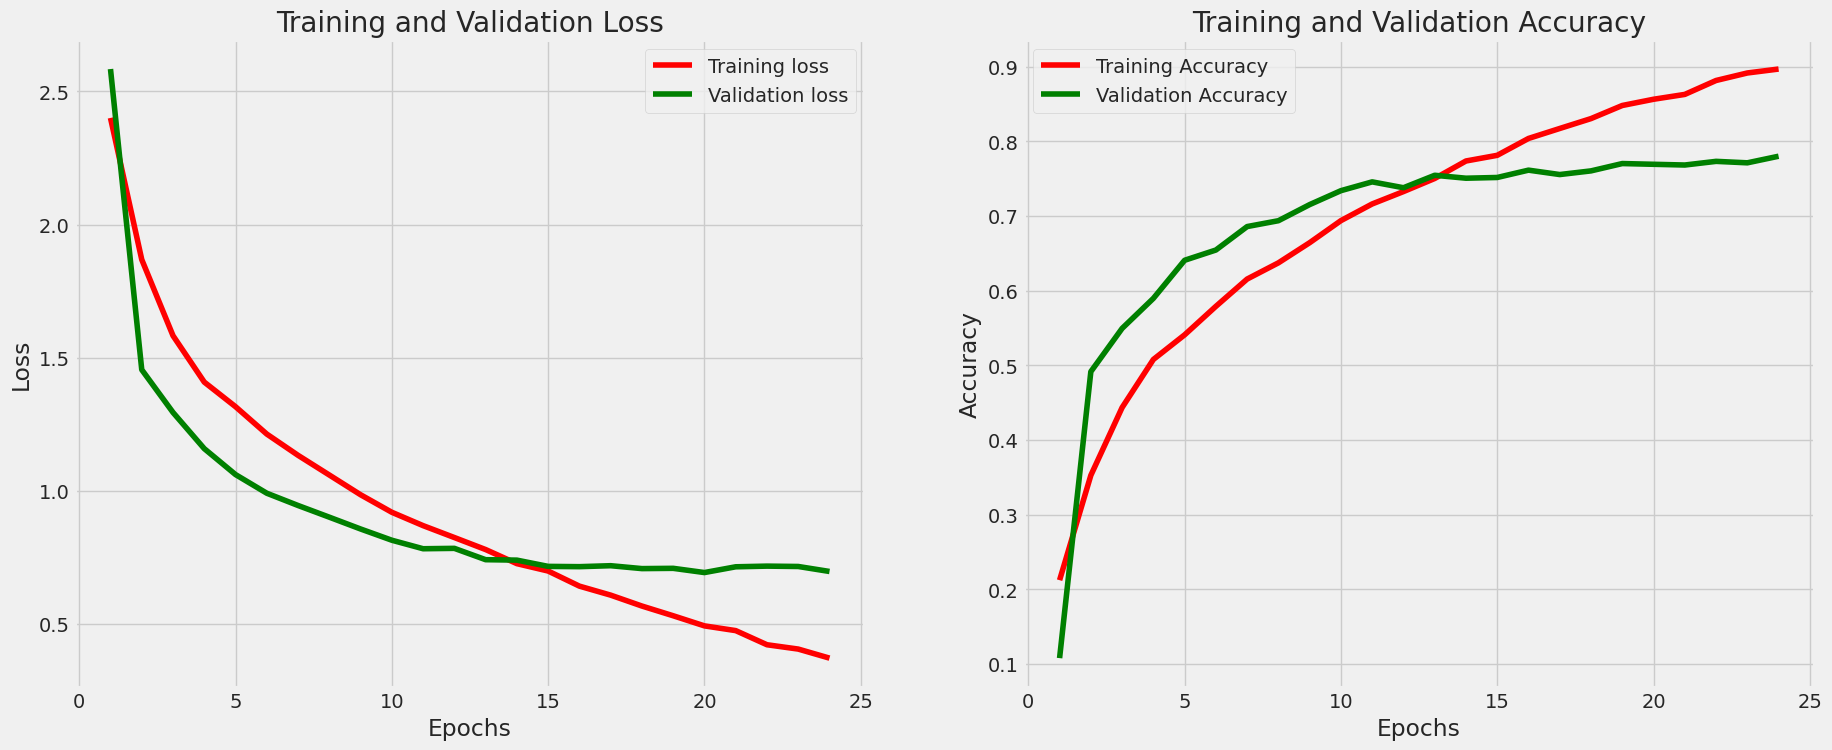

In [35]:
# Display model performance
model_performance(EfficientNetB3_history, epochs)

In [36]:
# Model evaluation
model_evaluation(EfficientNetB3_model)

510/510 ━━━━━━━━━━━━━━━━━━━━ 54s 105ms/step - accuracy: 0.9907 - loss: 0.0625


W0000 00:00:1716319632.985812     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.7658 - loss: 0.7443
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.7621 - loss: 0.7017
Train Loss:  0.06260345131158829
Train Accuracy:  0.9905544519424438
--------------------
Validation Loss:  0.6980634927749634
Validation Accuracy:  0.7801766395568848
--------------------
Test Loss:  0.6951029896736145
Test Accuracy:  0.774288535118103


 3/64 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step

W0000 00:00:1716319655.584024     175 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step


W0000 00:00:1716319670.045979     175 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


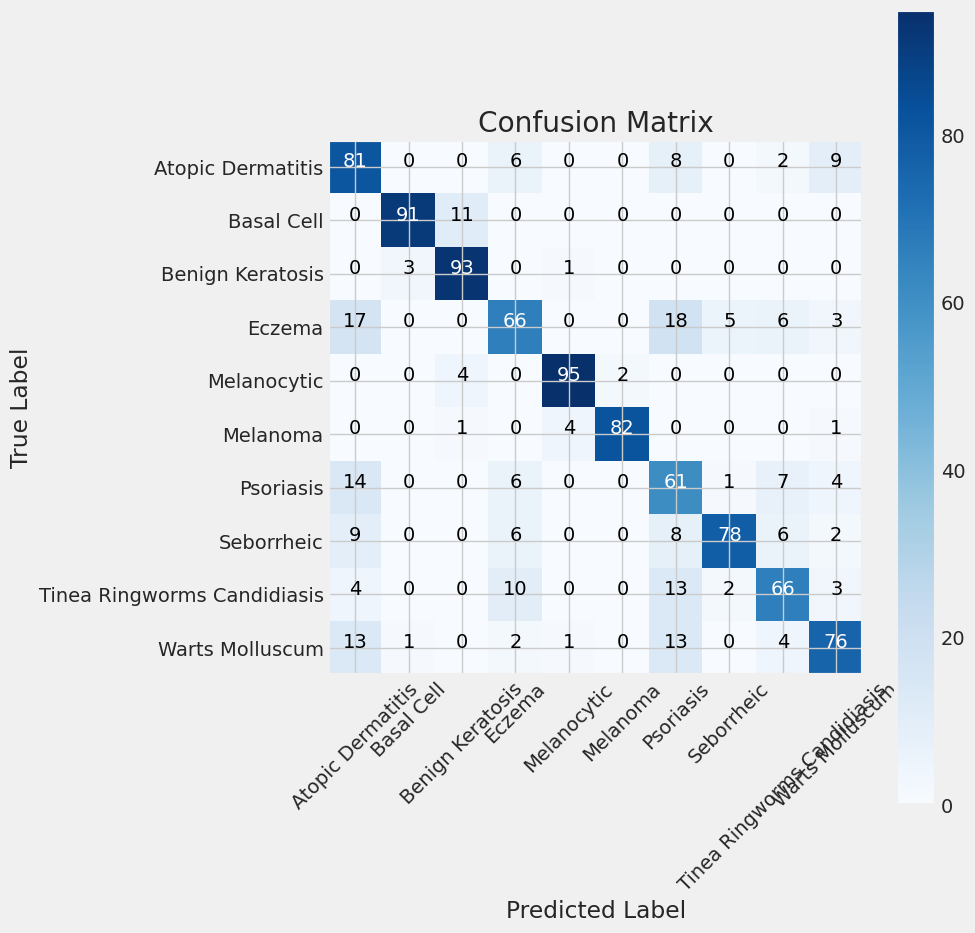

In [37]:
# get predictions
y_pred = get_pred(EfficientNetB3_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)

In [46]:
EfficientNetB3_model.save("EfficientNetB3_model.h5")

# VGG16

In [38]:
# get the pre-trained model (VGG16)
base_model = VGG16(weights='imagenet', include_top=False, input_shape = img_shape, pooling= 'max')

# freeze four convolution blocks
for layer in base_model.layers[:15]:
    layer.trainable = False
    
    
# fine-tune VGG16 (Adding some custom layers on top)
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.2)(x)   # # Dropout layer to prevent overfitting
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(32, activation = 'relu')(x)
predictions = Dense(class_counts, activation = "sigmoid")(x)    # output layer with softmax activation

# the model
VGG16_model = Model(inputs = base_model.input, outputs = predictions)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [39]:
# Check the trainable status of the layers
for layer in VGG16_model.layers:
    print(layer.name, layer.trainable)

input_layer_16 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
global_max_pooling2d True
flatten_1 True
dense_11 True
dropout_8 True
dense_12 True
dense_13 True
dense_14 True
dense_15 True


In [40]:
VGG16_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

VGG16_model.summary()

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,146,026 (57.78 MB)

 Trainable params: 7,510,762 (28.65 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [41]:
# train the model
epochs = 24   # number of all epochs in training

VGG16_history = VGG16_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/24
510/510 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.2025 - loss: 0.3780

W0000 00:00:1716319757.431124     176 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


510/510 ━━━━━━━━━━━━━━━━━━━━ 107s 162ms/step - accuracy: 0.2027 - loss: 0.3779 - val_accuracy: 0.4504 - val_loss: 0.2293
Epoch 2/24
510/510 ━━━━━━━━━━━━━━━━━━━━ 53s 104ms/step - accuracy: 0.4383 - loss: 0.2300 - val_accuracy: 0.5427 - val_loss: 0.2006
Epoch 3/24
510/510 ━━━━━━━━━━━━━━━━━━━━ 56s 110ms/step - accuracy: 0.5370 - loss: 0.1981 - val_accuracy: 0.5613 - val_loss: 0.1846
Epoch 4/24
510/510 ━━━━━━━━━━━━━━━━━━━━ 54s 105ms/step - accuracy: 0.5933 - loss: 0.1789 - val_accuracy: 0.5839 - val_loss: 0.1749
Epoch 5/24
510/510 ━━━━━━━━━━━━━━━━━━━━ 56s 109ms/step - accuracy: 0.6495 - loss: 0.1606 - val_accuracy: 0.6133 - val_loss: 0.1678
Epoch 6/24
510/510 ━━━━━━━━━━━━━━━━━━━━ 59s 116ms/step - accuracy: 0.6899 - loss: 0.1465 - val_accuracy: 0.6290 - val_loss: 0.1586
Epoch 7/24
510/510 ━━━━━━━━━━━━━━━━━━━━ 56s 110ms/step - accuracy: 0.7193 - loss: 0.1349 - val_accuracy: 0.6281 - val_loss: 0.1574
Epoch 8/24
510/510 ━━━━━━━━━━━━━━━━━━━━ 54s 106ms/step - accuracy: 0.7523 - loss: 0.1225 - va

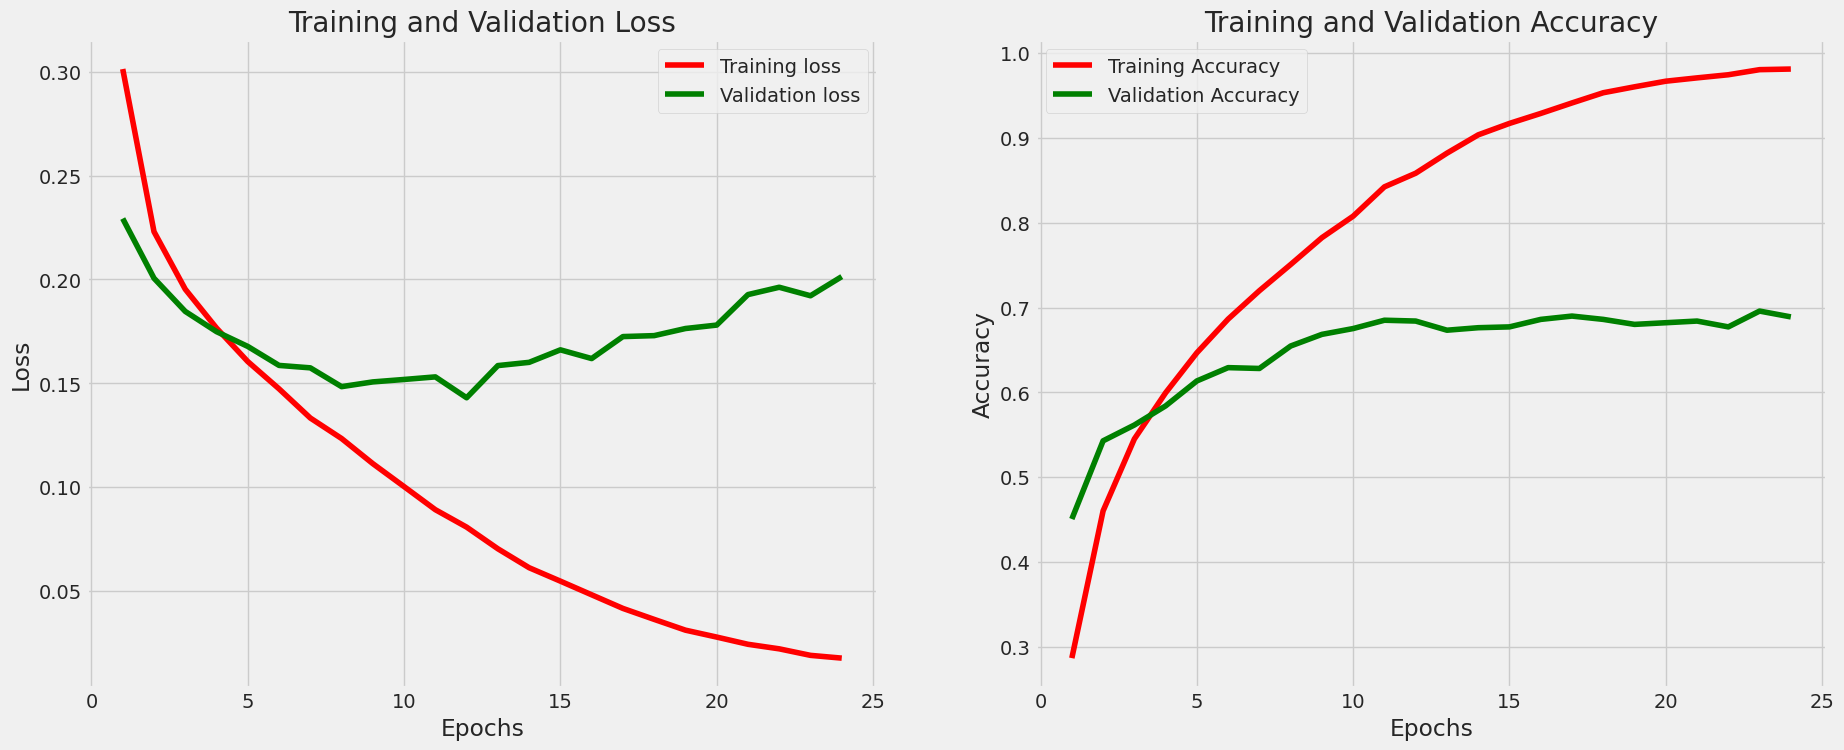

In [42]:
# Display model performance
model_performance(VGG16_history, epochs)

In [43]:
# Model evaluation
model_evaluation(VGG16_model)

510/510 ━━━━━━━━━━━━━━━━━━━━ 47s 92ms/step - accuracy: 0.9900 - loss: 0.0104


W0000 00:00:1716321112.033022     176 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.6901 - loss: 0.1938
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.7055 - loss: 0.2242
Train Loss:  0.010213249363005161
Train Accuracy:  0.9911677837371826
--------------------
Validation Loss:  0.20137633383274078
Validation Accuracy:  0.688910722732544
--------------------
Test Loss:  0.21399255096912384
Test Accuracy:  0.708537757396698


64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step


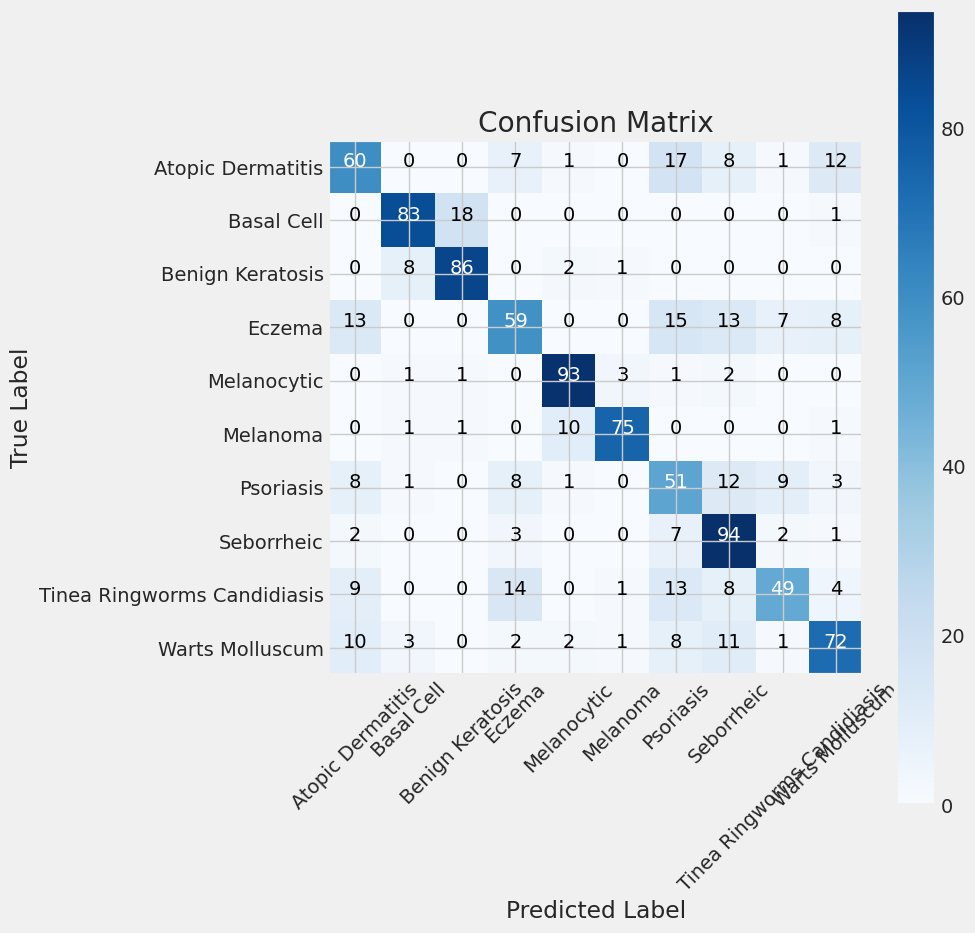

In [44]:
# get predictions
y_pred = get_pred(VGG16_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)

In [45]:
VGG16_model.save("VGG16_model.h5")